In [1]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter

#sentence transformer model for retrieval
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")

#GPT-3.5 for generation
import os
from getpass import getpass
from haystack.components.generators import OpenAIGenerator

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")
generator = OpenAIGenerator(model="gpt-3.5-turbo")

from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder

# Offline pipeline for adding documents

In [2]:
document_store = InMemoryDocumentStore()
document_writer = DocumentWriter(document_store)


In [3]:

pipeline = Pipeline()
pipeline.add_component("converter", PyPDFToDocument())
pipeline.add_component("cleaner", DocumentCleaner())
pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=5))
pipeline.add_component(instance=document_embedder, name="embedder")
pipeline.add_component("writer", DocumentWriter(document_store=document_store))

pipeline.connect("converter", "cleaner")
pipeline.connect("cleaner", "splitter")
pipeline.connect("splitter", "embedder")
pipeline.connect("embedder", "writer")

pipeline.run({"converter": {"sources": ["nvidia-10q-april-2024.pdf"]}})

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

{'writer': {'documents_written': 514}}

# Online pipeline

Enter OpenAI API key: ········


In [6]:
template = """
Answer the questions based on the given context. If the context is not relevant, say "I don't know"

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{ question }}
Answer:
"""
pipe = Pipeline()
pipe.add_component("embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store))
pipe.add_component("prompt_builder", PromptBuilder(template=template))
pipe.add_component("llm", generator)
pipe.connect("embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever", "prompt_builder.documents")
pipe.connect("prompt_builder", "llm")

🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [8]:
question = (
    "What was NVIDIA's earnings?"
)

pipe.run(
    {
        "embedder": {"text": question},
        "prompt_builder": {"question": question},
    }
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'llm': {'replies': ["NVIDIA's earnings were $14,881 million for the quarter ended April 28, 2024."],
  'meta': [{'model': 'gpt-3.5-turbo-0125',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 22,
     'prompt_tokens': 3104,
     'total_tokens': 3126}}]}}

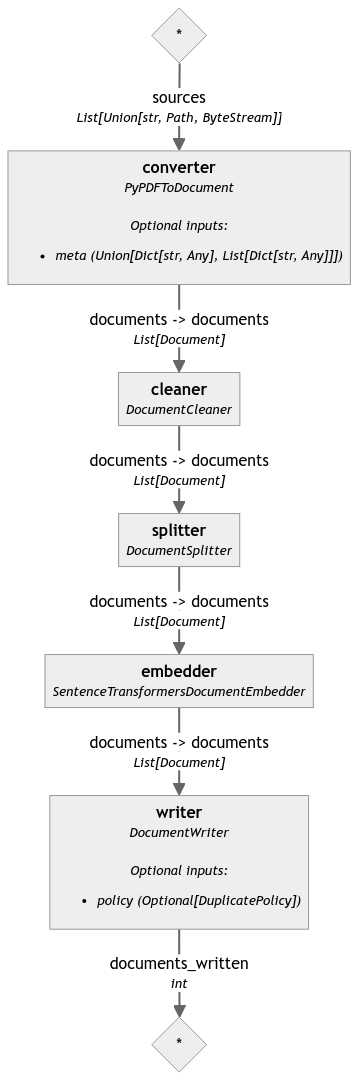

In [9]:
pipeline.show()

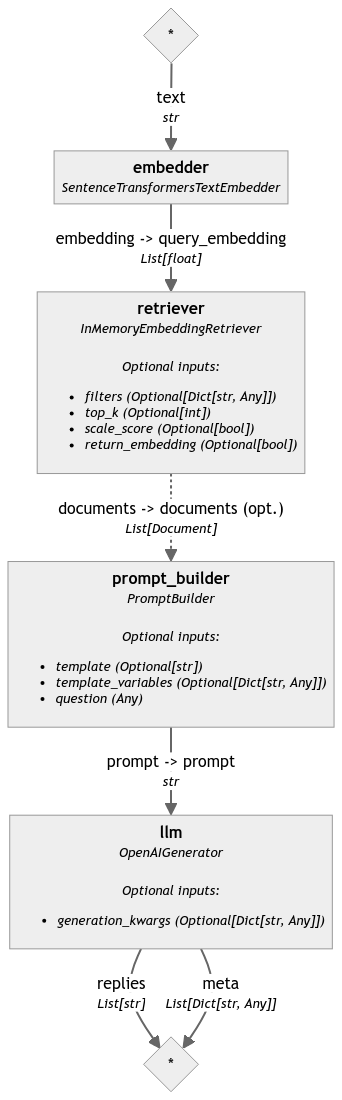

In [10]:
pipe.show()